# References

In [24]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys

#sys.path.append('../fastai/old/') #fastai version 0.7
#from old.fastai.conv_learner import *
#from old.fastai.dataset import *

sys.path.append('../fastai/') #fastai version 1
from fastai import *
from fastai.vision import *



import pdb
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pathlib
from pathlib import Path
from glob import glob
import png
from tqdm import tqdm_notebook as tqdm
import cv2
from sklearn.model_selection import train_test_split

In [2]:
torch.cuda.set_device(0)
torch.backends.cudnn.benchmark=True

# Global Variables

In [28]:
DP = Path('/home/Deep_Learner/work/datasets/human-protein-atlas-image-classification/')
STAGE_ONE_DATA = DP/'stage1_data'
TRAIN_PNGS = Path('train_pngs')
TRAIN_LABELS = Path('labels.csv')
TEST_PNGS = Path('test_pngs')
TRAIN_CSV = Path('train.csv')
SAMPLE_SUBMISSION_CSV = Path('sample_submission.csv')


SUBMISSIONS = DP/STAGE_ONE_DATA/'submissions'
SUBMISSIONS.mkdir(exist_ok=True)


filter_colors = ['blue', 'green', 'red', 'yellow']

IdToCatDict = {0:'Nucleoplasm',
               1:'Nuclear_membrane',
               2:'Nucleoli',
               3:'Nucleoli_fibrillar_center',
               4:'Nuclear_speckles',
               5:'Nuclear_bodies',
               6:'Endoplasmic_reticulum',
               7:'Golgi_apparatus',
               8:'Peroxisomes',
               9:'Endosomes',
               10:'Lysosomes',
               11:'Intermediate_filaments',
               12:'Actin_filaments',
               13:'Focal_adhesion_sites',
               14:'Microtubules',
               15:'Microtubule_ends',
               16:'Cytokinetic_bridge',
               17:'Mitotic_spindle',
               18:'Microtubule_organizing_center',
               19:'Centrosome',
               20:'Lipid_droplets',
               21:'Plasma_membrane',
               22:'Cell_junctions',
               23:'Mitochondria',
               24:'Aggresome',
               25:'Cytosol',
               26:'Cytoplasmic_bodies',
               27:'Rods_&_rings'}

sz = 128
bs = 16

# 1st try

## Data Setup

In [4]:
if os.path.isfile(STAGE_ONE_DATA/TRAIN_LABELS):
    trainFns_df = pd.read_csv(STAGE_ONE_DATA/TRAIN_LABELS)

else:
    trainIds_df = pd.read_csv(DP/'train.csv')
    trainFns_df = pd.DataFrame(columns=['name','label'])
    
    for index, row in tqdm(trainIds_df.iterrows(), total=trainIds_df.shape[0]):
        bn = row['Id']
        cats = row['Target']
        for c in filter_colors:
            fn = f'{bn}_{c}'
            trainFns_df = trainFns_df.append({'name': fn, 'label': cats}, ignore_index=True)
            
    trainFns_df.to_csv(STAGE_ONE_DATA/TRAIN_LABELS, index=False)


trainFns_df.head()

,name,label
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0_blue,16 0
1,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0_green,16 0
2,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0_red,16 0
3,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0_yellow,16 0
4,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0_blue,7 1 2 0


In [5]:
trainFns_df.shape

(124288, 2)

In [6]:
tfms = get_transforms(flip_vert=True)
stage1_data = ImageDataBunch.from_csv(path=STAGE_ONE_DATA, 
                                      folder=TRAIN_PNGS, 
                                      suffix='.png', 
                                      test=TEST_PNGS, 
                                      ds_tfms=tfms, 
                                      size=sz,
                                      valid_pct=0.1)

In [7]:
#stage1_data.show_batch(rows=5, figsize=(25,25))

## Train

In [20]:
learner = create_cnn(stage1_data, models.resnet152, metrics=[accuracy])

In [21]:
lr = 1e-2*1.8
lrs = np.array([lr/100,lr/10,lr])

In [22]:
learner.lr_find(start_lr=lrs/1000, end_lr=1)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


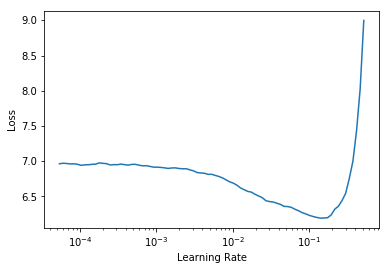

In [23]:
learner.recorder.plot()

In [10]:
callbacks = [ReduceLROnPlateauCallback(learn=learner, patience=8)]
learner.fit(epochs=100, lr=lrs, callbacks=callbacks)

epoch,train_loss,valid_loss,accuracy
1,4.533140,21.898252,0.081847
2,4.434938,4.593381,0.081928
3,4.347430,12.261543,0.098795
4,4.286415,6.621821,0.101767
5,4.275006,17.927334,0.110120
6,4.264586,19.454226,0.106506
7,4.248735,21.402931,0.107550
8,4.267242,23.128527,0.105703
9,4.241206,142.574554,0.101767
10,4.212318,25.531330,0.106827


Epoch 10: reducing lr to 0.0036000000000000008
Epoch 29: reducing lr to 0.0007200000000000002
Epoch 52: reducing lr to 0.00014400000000000003
Epoch 80: reducing lr to 2.880000000000001e-05


KeyboardInterrupt: 

# Data

In [16]:
p = pd.read_csv(DP/TRAIN_CSV).head()
p.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [20]:
 ü = p.ix[0,1].split()
ü

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


['16', '0']

In [21]:
ä = [int(ö)  for ö in ü ]
ä

[16, 0]

In [7]:
t = pd.read_csv(DP/SAMPLE_SUBMISSION_CSV)
t[0:20]

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,0
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,0
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0
5,00109f6a-bac8-11e8-b2b7-ac1f6b6435d0,0
6,001765de-bacd-11e8-b2b8-ac1f6b6435d0,0
7,0018641a-bac9-11e8-b2b8-ac1f6b6435d0,0
8,00200f22-bad7-11e8-b2b9-ac1f6b6435d0,0
9,0026f154-bac6-11e8-b2b7-ac1f6b6435d0,0


In [11]:
t.ix[0,0]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


'00008af0-bad0-11e8-b2b8-ac1f6b6435d0'

In [9]:
train_names = list(pd.read_csv(DP/TRAIN_CSV)['Id'])
test_names = list(pd.read_csv(DP/SAMPLE_SUBMISSION_CSV)['Id'])
tr_n, val_n = train_test_split(train_names, test_size=0.1, random_state=42)

In [10]:
def open_rgby(path,id): #a function that reads RGBY image
    colors = ['red','green','blue','yellow']
    flags = cv2.IMREAD_GRAYSCALE
    img = [cv2.imread(os.path.join(path, id+'_'+color+'.png'), flags).astype(np.float32)/255
           for color in colors]
    return np.stack(img, axis=-1)

In [30]:
class CustomDataset(Dataset):
    def __init__(self, 
                 path:pathlib.Path, 
                 csv_path:pathlib.Path, 
                 coloumn_idx_fns:int, 
                 coloumn_idx_targets:int, 
                 transform, 
                 isTest:bool, 
                 img_size:int):
        """
        write description here

        # Arguments
          path: pathlib.Path to images folder
          csv_path: pathlib.Path to csv file with coloums of image ids (without the colour suffix) and the targets as integers
                    separated with spaces
          transform: list of transform functions (e.g. from fastai.vision.transform)
          isTest: specify if it is a test set and therefore does not have labels
          coloumn_idx_fns: coloumn index in the csv file, where the filenames/fileindices are
          coloumn_idx_targets: coloumn index in the csv file, where the targets are
          img_size: size the images get resized to
          
        # Returns
        
        # Raises
        """

        self.df = pd.read_csv(csv_path)
        self.path = path
        self.transform = transform
        self.sz = img_size

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):    
        return self.__get_x(idx), self.__get_y(idx)

    
    def __get_x(self, idx):
        #img = open_rgby(self.path,self.df.ix[idx, coloumn_idx_fns])
        #return cv2.resize(img, (self.sz, self.sz),cv2.INTER_AREA)
        return open_rgby(self.path,self.df.ix[idx, coloumn_idx_fns])
    
    def __get_y(self, idx):
        if isTest:
            return [-1]
        label = self.df.ix[idx, coloumn_idx_targets].split()
        label = [int(s) for s in label]
        return label    

In [31]:
tmfs = tfms = get_transforms(flip_vert=True)
dataset = CustomDataset(path=STAGE_ONE_DATA/TRAIN_PNGS, 
                        csv_path=STAGE_ONE_DATA/TRAIN_CSV, 
                        coloumn_idx_fns=0, 
                        coloumn_idx_targets=1, 
                        transform=tfms, 
                        isTest=False, 
                        img_size=sz)

dataloader = DataLoader(dataset, batch_size=bs,
                        shuffle=True, num_workers=4)
bunch = ImageDataBunch(dataloader, dataloader)
bunch.show_batch(rows=3)

AttributeError: 'CustomDataset' object has no attribute 'classes'

In [ ]:
ImageDataBunch()